# Week 5: RNN, LSTM, & Transformer

## Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.utils import timeseries_dataset_from_array
from keras import layers, models, Input
from sklearn.preprocessing import MinMaxScaler
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import math
from sklearn.metrics import mean_squared_error

## Loading Dataset and Preprocessing

In [2]:
df = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [3]:
# Convert date
df["Date"] = pd.to_datetime(df["Date"]).map(pd.Timestamp.toordinal)
dates = df["Date"].copy()

# Drop non-numeric column
# df = df.drop(columns=["Name"])
df = df.drop(columns=["Name", "Date"])

# Select input features and target
# feature_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
feature_cols = ["Open", "High", "Low", "Close", "Volume"]
X_raw = df[feature_cols].values
y_raw = df["Close"].values.reshape(-1, 1)

In [4]:
# Scale inputs
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X_raw)

# Scale target
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y_raw)


## Train-test split

In [25]:
seq_len = 50
forecast_horizon = 7 # predict 7 days ahead

X_data = X_scaled       # (N, 5)
y_data = y_scaled       # (N, 1)

total_shift = seq_len + forecast_horizon - 1

seq_len = 50
forecast_horizon = 7  # predict 7 days ahead

X_data = X_scaled       # (N, 5)
y_data = y_scaled       # (N, 1)

total_shift = seq_len + forecast_horizon - 1

# Align X and y
X_trimmed = X_data[:-total_shift]
y_shifted = y_data[total_shift:]

n_total = len(X_trimmed)

train_end = int(n_total * 0.70)
test_end  = int(n_total * 0.90)   # 70% + 20% = 90%

# ---- Split ----
X_train = X_trimmed[:train_end]
y_train = y_shifted[:train_end]

X_test = X_trimmed[train_end:test_end]
y_test = y_shifted[train_end:test_end]

X_val = X_trimmed[test_end:]
y_val = y_shifted[test_end:]

train_data = tf.keras.utils.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=seq_len,
    sequence_stride=1,
    shuffle=True,
    batch_size=32,
)

test_data = tf.keras.utils.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=seq_len,
    sequence_stride=1,
    shuffle=False,
    batch_size=32,
)

val_data = tf.keras.utils.timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=seq_len,
    sequence_stride=1,
    shuffle=False,
    batch_size=32,
)



## RNN

In [26]:
model_rnn = models.Sequential([
    Input(shape=(seq_len, 5)),
    layers.SimpleRNN(64, return_sequences=True),  # , input_shape=(seq_len, 5)),
    layers.Dropout(0.2),

    layers.SimpleRNN(64),
    layers.Dropout(0.2),

    layers.Dense(32, activation="relu"),
    layers.Dense(1),
])

model_rnn.compile(optimizer="adam", loss="mse")

history = model_rnn.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
64/64 [==============================] - 2s 16ms/step - loss: 0.0205 - val_loss: 0.0263
Epoch 2/10
64/64 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.1139
Epoch 3/10
64/64 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0534
Epoch 4/10
64/64 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.0695
Epoch 5/10
64/64 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0677
Epoch 6/10
64/64 [==============================] - 1s 10ms/step - loss: 9.6144e-04 - val_loss: 0.0682
Epoch 7/10
64/64 [==============================] - 1s 10ms/step - loss: 7.7348e-04 - val_loss: 0.0699
Epoch 8/10
64/64 [==============================] - 1s 12ms/step - loss: 6.8624e-04 - val_loss: 0.0659
Epoch 9/10
64/64 [==============================] - 1s 11ms/step - loss: 5.6350e-04 - val_loss: 0.0730
Epoch 10/10
64/64 [==============================] - 1s 11ms/step - loss: 5.9723e-04 - val_lo

In [27]:
def plot_train_test_predictions(train, test_true, test_pred, dates, title):
    plt.figure(figsize=(14, 5))

    # X-axis indices
    train_x = np.arange(len(train))
    test_x = np.arange(len(train), len(train) + len(test_true))

    # Plot lines
    plt.plot(train_x, train, label="Training Price")
    plt.plot(test_x, test_true, label="True Test Price")
    plt.plot(test_x, test_pred, label="Predicted Test Price")

    # Convert ordinal dates to actual datetime
    dates = dates.apply(pd.Timestamp.fromordinal)

    # Build date array for the entire plotted range
    all_dates = dates[:len(train) + len(test_true)]

    # Find the FIRST available date of each year
    tick_idx = []
    tick_labels = []
    seen_years = set()

    for i, d in enumerate(all_dates):
        if d.year not in seen_years:
            seen_years.add(d.year)
            tick_idx.append(i)
            tick_labels.append(str(d.year))

    # Apply ticks
    plt.xticks(tick_idx, tick_labels, rotation=45)

    plt.xlabel("Date")
    plt.ylabel("AMZN Close Price ($)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


17/17 [==============================] - 1s 22ms/step


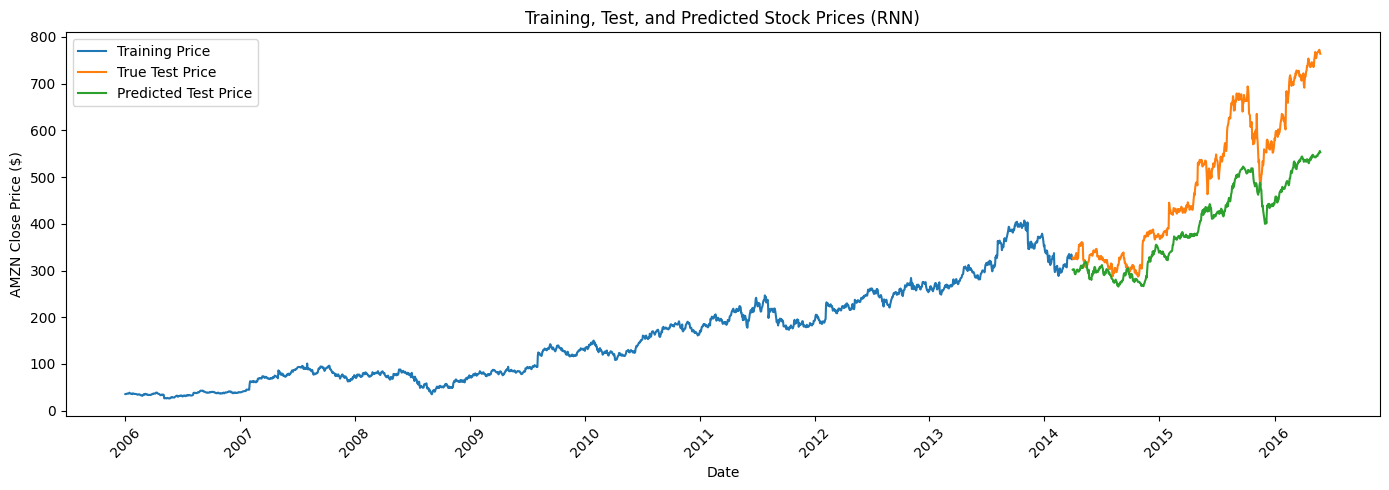

In [28]:
pred_scaled = model_rnn.predict(test_data)
true_scaled = np.concatenate([y for X, y in test_data], axis=0)

pred = target_scaler.inverse_transform(pred_scaled).flatten()
true = target_scaler.inverse_transform(true_scaled).flatten()

data = target_scaler.inverse_transform(y_train).flatten()

plot_train_test_predictions(
    train=data,
    test_true=true,
    test_pred=pred,
    # dates=df["Date"],
    dates=dates,
    title="Training, Test, and Predicted Stock Prices (RNN)"
)


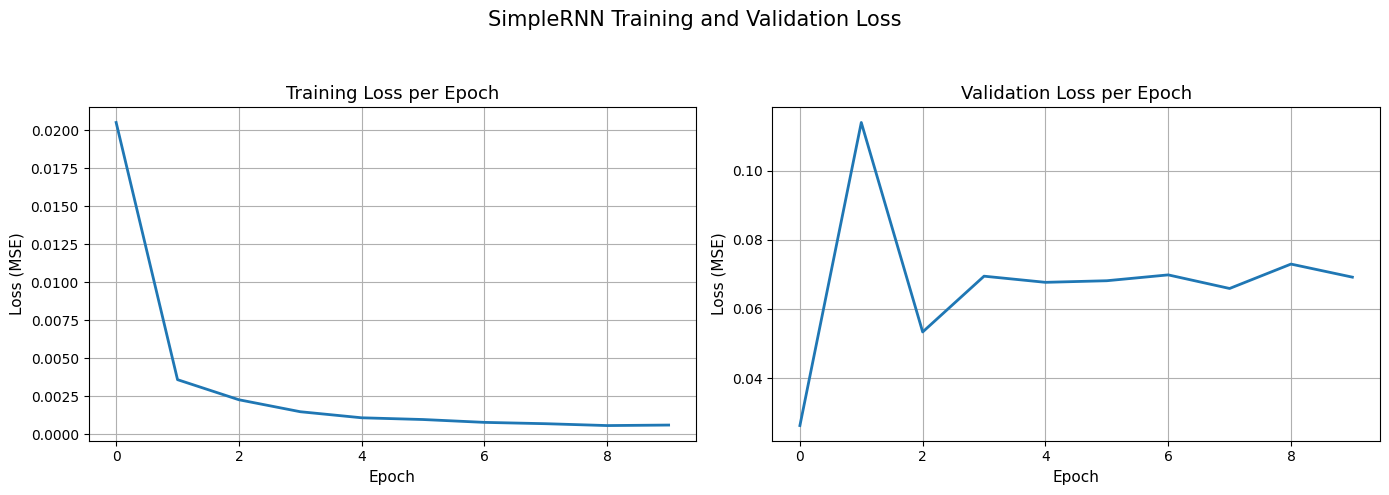

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
axes[0].plot(history.history['loss'], linewidth=2)
axes[0].set_title("Training Loss per Epoch", fontsize=13)
axes[0].set_xlabel("Epoch", fontsize=11)
axes[0].set_ylabel("Loss (MSE)", fontsize=11)
axes[0].grid(True)

# Validation loss
axes[1].plot(history.history['val_loss'], linewidth=2)
axes[1].set_title("Validation Loss per Epoch", fontsize=13)
axes[1].set_xlabel("Epoch", fontsize=11)
axes[1].set_ylabel("Loss (MSE)", fontsize=11)
axes[1].grid(True)

# Main title
fig.suptitle("SimpleRNN Training and Validation Loss", fontsize=15)

# Adjust layout to make space for main title
plt.tight_layout(rect=[0, 0, 1, 0.93])

plt.show()


## LSTM

In [32]:
model = models.Sequential([
    Input(shape=(seq_len, 5)),
    layers.LSTM(128, return_sequences=True),  # , input_shape=(seq_len, 5)),
    layers.Dropout(0.2),
    layers.LSTM(64),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)

Epoch 1/10
64/64 [==============================] - 5s 43ms/step - loss: 9.7697e-04 - val_loss: 0.0157
Epoch 2/10
64/64 [==============================] - 3s 40ms/step - loss: 1.9099e-04 - val_loss: 0.0050
Epoch 3/10
64/64 [==============================] - 2s 37ms/step - loss: 2.1586e-04 - val_loss: 0.0077
Epoch 4/10
64/64 [==============================] - 3s 42ms/step - loss: 1.7237e-04 - val_loss: 0.0122
Epoch 5/10
64/64 [==============================] - 2s 37ms/step - loss: 1.4925e-04 - val_loss: 0.0076
Epoch 6/10
64/64 [==============================] - 3s 41ms/step - loss: 1.4512e-04 - val_loss: 0.0067
Epoch 7/10
64/64 [==============================] - 2s 38ms/step - loss: 1.4341e-04 - val_loss: 0.0122
Epoch 8/10
64/64 [==============================] - 3s 40ms/step - loss: 1.3629e-04 - val_loss: 0.0111
Epoch 9/10
64/64 [==============================] - 2s 38ms/step - loss: 1.4023e-04 - val_loss: 0.0125
Epoch 10/10
64/64 [==============================] - 3s 41ms/step - loss:

17/17 [==============================] - 1s 13ms/step


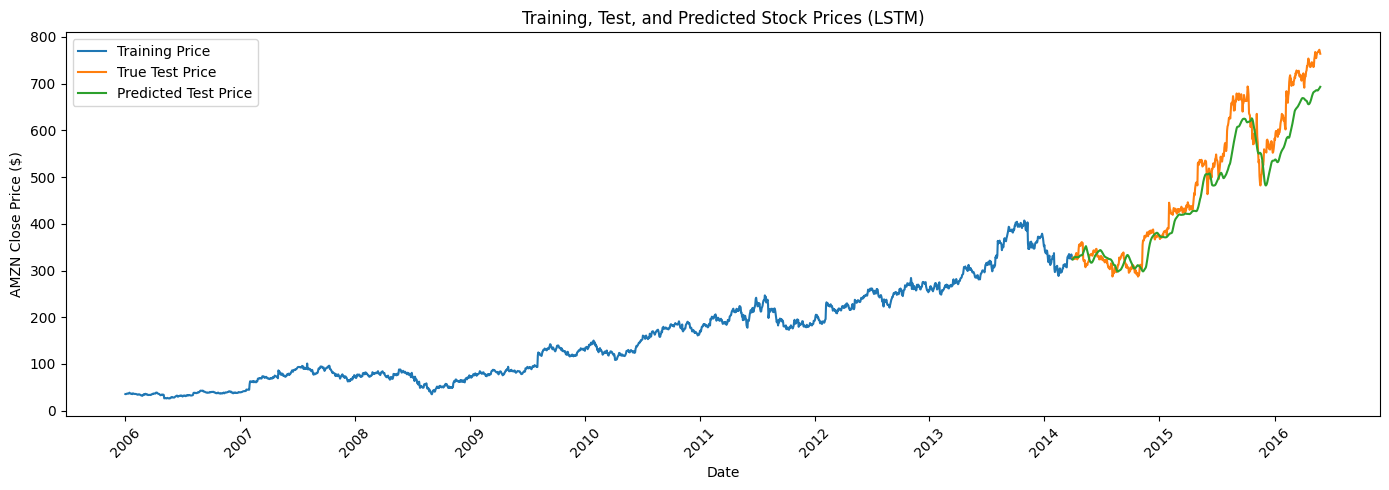

In [33]:
pred_scaled = model.predict(test_data)
true_scaled = np.concatenate([y for X, y in test_data], axis=0)

pred = target_scaler.inverse_transform(pred_scaled).flatten()
true = target_scaler.inverse_transform(true_scaled).flatten()

data = target_scaler.inverse_transform(y_train).flatten()

plot_train_test_predictions(
    train=data,
    test_true=true,
    test_pred=pred,
    # dates=df["Date"],
    dates=dates,
    title="Training, Test, and Predicted Stock Prices (LSTM)"
)


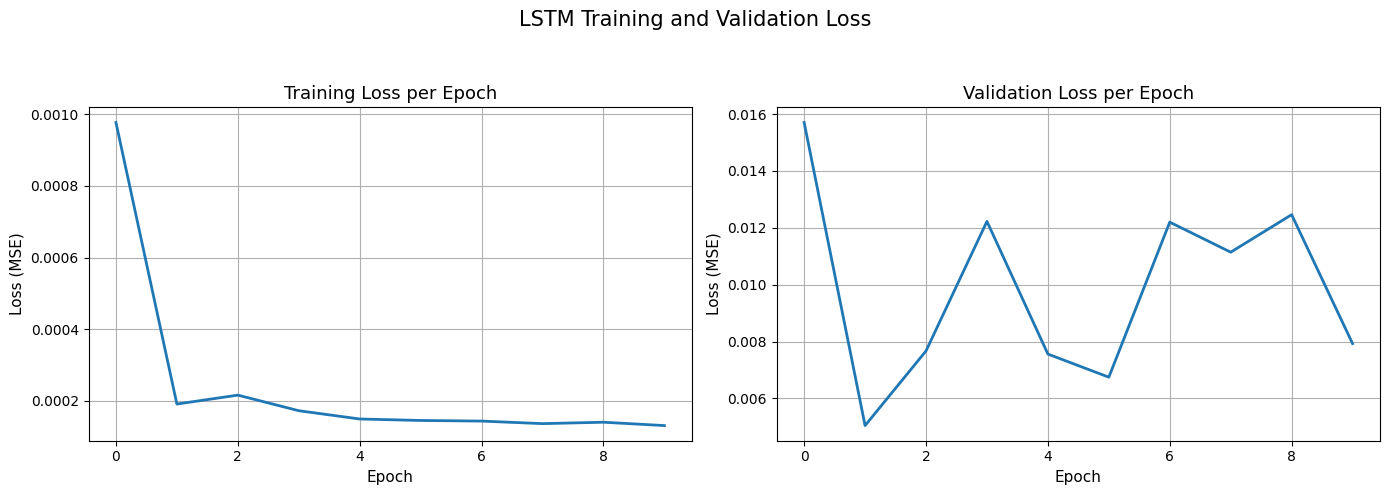

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
axes[0].plot(history.history['loss'], linewidth=2)
axes[0].set_title("Training Loss per Epoch", fontsize=13)
axes[0].set_xlabel("Epoch", fontsize=11)
axes[0].set_ylabel("Loss (MSE)", fontsize=11)
axes[0].grid(True)

# Validation loss
axes[1].plot(history.history['val_loss'], linewidth=2)
axes[1].set_title("Validation Loss per Epoch", fontsize=13)
axes[1].set_xlabel("Epoch", fontsize=11)
axes[1].set_ylabel("Loss (MSE)", fontsize=11)
axes[1].grid(True)


fig.suptitle("LSTM Training and Validation Loss", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


## Transformer

### Multi step forecasing of 7 days

In [35]:
# Read Data, convert to sequences, split into train and test sets and load into DataLoaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)
features = ["Open","Close","Volume","High","Low"]
TARGET = "Close"
TARGET_IDX = features.index(TARGET)
data = df[features].values.astype(np.float32)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
SEQ_LEN = 90
TRAIN_RATIO = 0.7
FORECAST_HORIZON = 7

def create_sequences(arr, target_idx, seq_len, horizon):
    X, y = [], []
    for i in range(len(arr) - seq_len - horizon + 1):
        X.append(arr[i : i + seq_len])
        y.append(arr[i + seq_len : i + seq_len + horizon, target_idx])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(data_scaled, TARGET_IDX, SEQ_LEN, FORECAST_HORIZON)

N = len(X_all)

train_end = int(N * TRAIN_RATIO)
test_end  = int(N * 0.90)   # 70% + 20%
train_size = int(N * TRAIN_RATIO)
# ---- Train ----
X_train = torch.tensor(X_all[:train_end], dtype=torch.float32).to(device)
y_train = torch.tensor(y_all[:train_end], dtype=torch.float32).to(device)

# ---- Test ----
X_test = torch.tensor(X_all[train_end:test_end], dtype=torch.float32).to(device)
y_test = torch.tensor(y_all[train_end:test_end], dtype=torch.float32).to(device)

# ---- Validation ----
X_val = torch.tensor(X_all[test_end:], dtype=torch.float32).to(device)
y_val = torch.tensor(y_all[test_end:], dtype=torch.float32).to(device)


train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=1,
    shuffle=False
)

val_loader = DataLoader(
    TensorDataset(X_val, y_val),
    batch_size=1,
    shuffle=False
)

NUM_FEATURES = X_all.shape[-1]

In [50]:
# Add positional encoding for Transformer model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5_000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10_000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer("pe", pe.unsqueeze(0))  

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]

# Create causal mask for decoder self-attention
def causal_mask(seq_len, device):
    return torch.triu(
        torch.ones(seq_len, seq_len, device=device, dtype=torch.bool),
        diagonal=1
    )

# Transformer Encoder and Decoder Blocks
class EncoderBlock(nn.Module):
    # Encoder block with multi-head self-attention, feed-forward network, layer norm, and dropout
    def __init__(self, d_model, heads, d_ff, dropout):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            d_model, heads, dropout=dropout, batch_first=True
        )
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, S, d_model)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + self.drop(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.drop(ff_out))
        return x


class DecoderBlock(nn.Module):
    # Decoder block with self-attention, cross-attention, feed-forward network, layer norm, and dropout
    def __init__(self, d_model, heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(
            d_model, heads, dropout=dropout, batch_first=True
        )
        self.cross_attn = nn.MultiheadAttention(
            d_model, heads, dropout=dropout, batch_first=True
        )

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, enc_output, tgt_mask):
        self_attn_out, _ = self.self_attn(
            x, x, x, attn_mask=tgt_mask
        )
        x = self.norm1(x + self.drop(self_attn_out))

        cross_attn_out, _ = self.cross_attn(
            x, enc_output, enc_output
        )
        x = self.norm2(x + self.drop(cross_attn_out))

        ff_out = self.ff(x)
        x = self.norm3(x + self.drop(ff_out))
        return x


class Seq2SeqTransformer(nn.Module):
    # Seq2Seq Transformer for time series forecasting with 6 stacked encoder and decoder blocks
    def __init__(self, input_dim, d_model=128, heads=4, layers=6,
                 d_ff=512, dropout=0.1, output_len=7):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.output_len = output_len

        # Encoder
        self.enc_proj = nn.Linear(input_dim, d_model)
        self.encoder = nn.ModuleList([
            EncoderBlock(d_model, heads, d_ff, dropout)
            for _ in range(layers)
        ])
        # Decoder
        self.dec_value_proj = nn.Linear(1, d_model)
        self.decoder = nn.ModuleList([
            DecoderBlock(d_model, heads, d_ff, dropout)
            for _ in range(layers)
        ])
        # positional encoding
        self.pos = PositionalEncoding(d_model)
        self.fc = nn.Linear(d_model, 1)
        self.drop = nn.Dropout(dropout)

    def encode(self, x):
        x = self.enc_proj(x) * math.sqrt(self.d_model)  
        x = self.pos(x)
        for block in self.encoder:
            x = block(x)
        return x

    def decode_teacher_forcing(self, enc_output, x, y):
        # Decoder during training: uses real target values (teacher forcing) to prevent error accumulation
        B = x.size(0)
        device = x.device
        last_target = x[:, -1, -1].unsqueeze(1)  # (B, 1)
        y_prev = torch.cat([last_target, y[:, :-1]], dim=1) 

        dec_vals = y_prev.unsqueeze(-1)  
        dec_input = self.dec_value_proj(dec_vals) * math.sqrt(self.d_model)
        dec_input = self.pos(dec_input)
        dec_input = self.drop(dec_input)

        S_dec = dec_input.size(1)
        tgt_mask = causal_mask(S_dec, device) 

        dec_output = dec_input
        for block in self.decoder:
            dec_output = block(dec_output, enc_output, tgt_mask)

        preds = self.fc(dec_output).squeeze(-1)  
        return preds

    def decode_autoregressive(self, enc_output, x):
        # Decode block used during inference, which uses its own previous predictions
        B = x.size(0)
        device = x.device
        last_target = x[:, -1, -1].unsqueeze(1) 
        prev_y = last_target  

        preds = []
        dec_vals = None 

        for t in range(self.output_len):
            if dec_vals is None:
                dec_vals = prev_y.unsqueeze(-1) 
            else:
                dec_vals = torch.cat([dec_vals, prev_y.unsqueeze(-1)], dim=1)  

            dec_input = self.dec_value_proj(dec_vals) * math.sqrt(self.d_model)
            dec_input = self.pos(dec_input)
            dec_input = self.drop(dec_input)

            S_dec = dec_input.size(1)
            tgt_mask = causal_mask(S_dec, device)

            dec_output = dec_input
            for block in self.decoder:
                dec_output = block(dec_output, enc_output, tgt_mask)

            step_pred = self.fc(dec_output[:, -1, :]).squeeze(-1)  
            preds.append(step_pred.unsqueeze(1))  

            prev_y = step_pred.unsqueeze(1)  

        preds = torch.cat(preds, dim=1)
        return preds

    def forward(self, x, y=None):
        enc_output = self.encode(x)

        if self.training and (y is not None):
            return self.decode_teacher_forcing(enc_output, x, y)
        else:
            return self.decode_autoregressive(enc_output, x)

In [53]:
model = Seq2SeqTransformer(
    input_dim=NUM_FEATURES,
    d_model=128,
    heads=4,
    layers=3,
    d_ff=512,
    dropout=0.1,
    output_len=FORECAST_HORIZON
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 25
print("Training Seq2Seq Transformer...")

train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_epoch_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()

        preds = model(xb, yb)
        loss = loss_fn(preds, yb)

        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()

    avg_train_loss = train_epoch_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # validation
    model.eval()
    val_epoch_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model(xb, yb)
            loss = loss_fn(preds, yb)

            val_epoch_loss += loss.item()

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {avg_train_loss:.6f} | "
        f"Val Loss: {avg_val_loss:.6f}"
    )


Training Seq2Seq Transformer...
Epoch 1/25 | Train Loss: 0.047529 | Val Loss: 0.055601
Epoch 2/25 | Train Loss: 0.008875 | Val Loss: 0.066448
Epoch 3/25 | Train Loss: 0.004836 | Val Loss: 0.059622
Epoch 4/25 | Train Loss: 0.002989 | Val Loss: 0.056221
Epoch 5/25 | Train Loss: 0.002006 | Val Loss: 0.048500
Epoch 6/25 | Train Loss: 0.001401 | Val Loss: 0.053680
Epoch 7/25 | Train Loss: 0.001066 | Val Loss: 0.056250
Epoch 8/25 | Train Loss: 0.000829 | Val Loss: 0.060957
Epoch 9/25 | Train Loss: 0.000711 | Val Loss: 0.057514
Epoch 10/25 | Train Loss: 0.000571 | Val Loss: 0.057392
Epoch 11/25 | Train Loss: 0.000512 | Val Loss: 0.056565
Epoch 12/25 | Train Loss: 0.000432 | Val Loss: 0.065789
Epoch 13/25 | Train Loss: 0.000429 | Val Loss: 0.060473
Epoch 14/25 | Train Loss: 0.000355 | Val Loss: 0.067822
Epoch 15/25 | Train Loss: 0.000328 | Val Loss: 0.058090
Epoch 16/25 | Train Loss: 0.000308 | Val Loss: 0.058600
Epoch 17/25 | Train Loss: 0.000273 | Val Loss: 0.067087
Epoch 18/25 | Train Loss:

--------------------
H=7 Day Ahead Forecast
 MSE:  10374.8676
 RMSE: 101.8571
--------------------


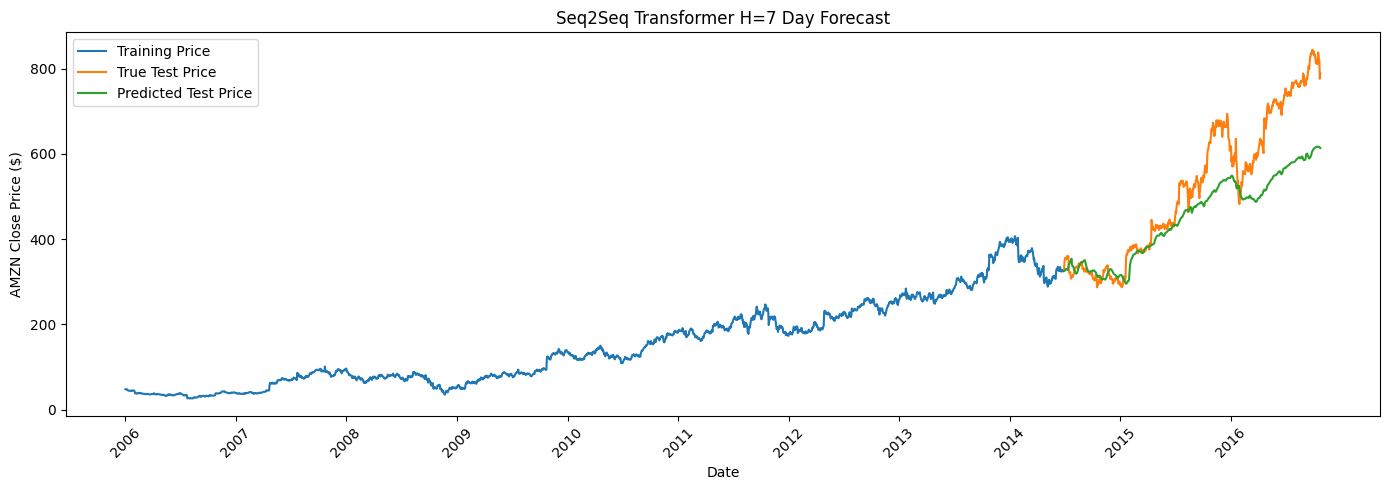

In [54]:
model.eval()
preds_scaled = []

with torch.no_grad():
    for xb, _ in test_loader:
        pred = model(xb.to(device))        
        pred = pred.cpu().numpy()
        preds_scaled.append(pred)

preds_scaled = np.vstack(preds_scaled)       
y_test_scaled = y_test.cpu().numpy()         


preds_h7 = preds_scaled[:, 6:7]  
true_h7  = y_test_scaled[:, 6:7]  

# inverse transform to get back true values
dummy_pred = np.zeros((len(preds_h7), data.shape[1]))
dummy_true = np.zeros((len(true_h7), data.shape[1]))

dummy_pred[:, TARGET_IDX] = preds_h7[:, 0]
dummy_true[:, TARGET_IDX] = true_h7[:, 0]

pred_close_h7 = scaler.inverse_transform(dummy_pred)[:, TARGET_IDX]
true_close_h7 = scaler.inverse_transform(dummy_true)[:, TARGET_IDX]

# metrics
mse_h7 = mean_squared_error(true_close_h7, pred_close_h7)
rmse_h7 = np.sqrt(mse_h7)

print("-" * 20)
print("H=7 Day Ahead Forecast")
print(f" MSE:  {mse_h7:.4f}")
print(f" RMSE: {rmse_h7:.4f}")
print("-" * 20)

plot_train = df["Close"].iloc[: train_size + SEQ_LEN].values
plot_dates = df["Date"].iloc[
    train_size + SEQ_LEN : train_size + SEQ_LEN + len(true_close_h7)
].apply(lambda x: x.toordinal())

plot_train_test_predictions(
    train=plot_train,
    test_true=true_close_h7,
    test_pred=pred_close_h7,
    dates=dates,
    title="Seq2Seq Transformer H=7 Day Forecast"
)

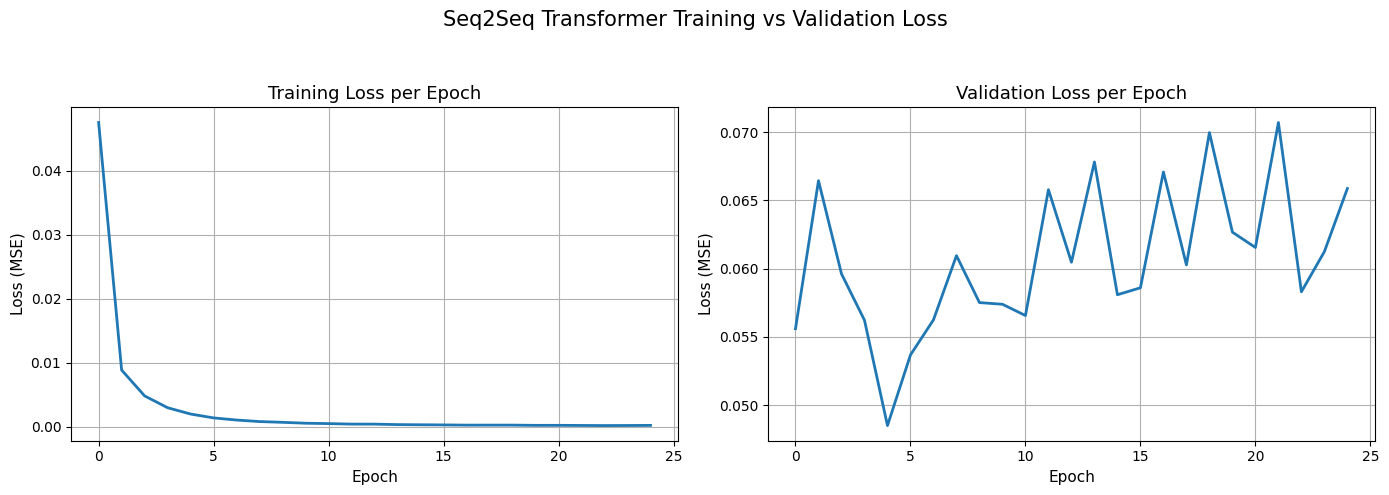

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
axes[0].plot(train_loss_history, linewidth=2)
axes[0].set_title("Training Loss per Epoch", fontsize=13)
axes[0].set_xlabel("Epoch", fontsize=11)
axes[0].set_ylabel("Loss (MSE)", fontsize=11)
axes[0].grid(True)

# Validation loss
axes[1].plot(val_loss_history, linewidth=2)
axes[1].set_title("Validation Loss per Epoch", fontsize=13)
axes[1].set_xlabel("Epoch", fontsize=11)
axes[1].set_ylabel("Loss (MSE)", fontsize=11)
axes[1].grid(True)

# Main title
fig.suptitle("Seq2Seq Transformer Training vs Validation Loss", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.93])

plt.show()


### Multi-step forecasting of 10 days

In [56]:
# Read Data, convert to sequences, split into train and test sets and load into DataLoaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)
features = ["Open","Close","Volume","High","Low"]
TARGET = "Close"
TARGET_IDX = features.index(TARGET)
data = df[features].values.astype(np.float32)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
SEQ_LEN = 90
TRAIN_RATIO = 0.7
FORECAST_HORIZON = 10

def create_sequences(arr, target_idx, seq_len, horizon):
    X, y = [], []
    for i in range(len(arr) - seq_len - horizon + 1):
        X.append(arr[i : i + seq_len])
        y.append(arr[i + seq_len : i + seq_len + horizon, target_idx])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(data_scaled, TARGET_IDX, SEQ_LEN, FORECAST_HORIZON)

N = len(X_all)

train_end = int(N * TRAIN_RATIO)
test_end  = int(N * 0.90)   # 70% + 20%
train_size = int(N * TRAIN_RATIO)
# ---- Train ----
X_train = torch.tensor(X_all[:train_end], dtype=torch.float32).to(device)
y_train = torch.tensor(y_all[:train_end], dtype=torch.float32).to(device)

# ---- Test ----
X_test = torch.tensor(X_all[train_end:test_end], dtype=torch.float32).to(device)
y_test = torch.tensor(y_all[train_end:test_end], dtype=torch.float32).to(device)

# ---- Validation ----
X_val = torch.tensor(X_all[test_end:], dtype=torch.float32).to(device)
y_val = torch.tensor(y_all[test_end:], dtype=torch.float32).to(device)


train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=1,
    shuffle=False
)

val_loader = DataLoader(
    TensorDataset(X_val, y_val),
    batch_size=1,
    shuffle=False
)

NUM_FEATURES = X_all.shape[-1]

In [57]:
model_10 = Seq2SeqTransformer(
    input_dim=NUM_FEATURES,
    d_model=128,
    heads=4,
    layers=3,
    d_ff=512,
    dropout=0.1,
    output_len=FORECAST_HORIZON
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=1e-4)

EPOCHS = 25
print("Training Seq2Seq Transformer...")

train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):
    # Train
    model_10.train()
    train_epoch_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()

        preds = model_10(xb, yb)
        loss = loss_fn(preds, yb)

        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()

    avg_train_loss = train_epoch_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # validation
    model_10.eval()
    val_epoch_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model_10(xb, yb)
            loss = loss_fn(preds, yb)

            val_epoch_loss += loss.item()

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {avg_train_loss:.6f} | "
        f"Val Loss: {avg_val_loss:.6f}"
    )


Training Seq2Seq Transformer...
Epoch 1/25 | Train Loss: 0.062862 | Val Loss: 0.050309
Epoch 2/25 | Train Loss: 0.010838 | Val Loss: 0.047482
Epoch 3/25 | Train Loss: 0.006199 | Val Loss: 0.062201
Epoch 4/25 | Train Loss: 0.003914 | Val Loss: 0.059422
Epoch 5/25 | Train Loss: 0.002574 | Val Loss: 0.067745
Epoch 6/25 | Train Loss: 0.001806 | Val Loss: 0.084841
Epoch 7/25 | Train Loss: 0.001321 | Val Loss: 0.076544
Epoch 8/25 | Train Loss: 0.001015 | Val Loss: 0.091357
Epoch 9/25 | Train Loss: 0.000827 | Val Loss: 0.095667
Epoch 10/25 | Train Loss: 0.000734 | Val Loss: 0.102956
Epoch 11/25 | Train Loss: 0.000641 | Val Loss: 0.112954
Epoch 12/25 | Train Loss: 0.000556 | Val Loss: 0.109714
Epoch 13/25 | Train Loss: 0.000503 | Val Loss: 0.125968
Epoch 14/25 | Train Loss: 0.000505 | Val Loss: 0.118789
Epoch 15/25 | Train Loss: 0.000464 | Val Loss: 0.127342
Epoch 16/25 | Train Loss: 0.000394 | Val Loss: 0.129468
Epoch 17/25 | Train Loss: 0.000399 | Val Loss: 0.140080
Epoch 18/25 | Train Loss:

--------------------
H=10 Day Ahead Forecast
 MSE:  28171.7527
 RMSE: 167.8444
--------------------


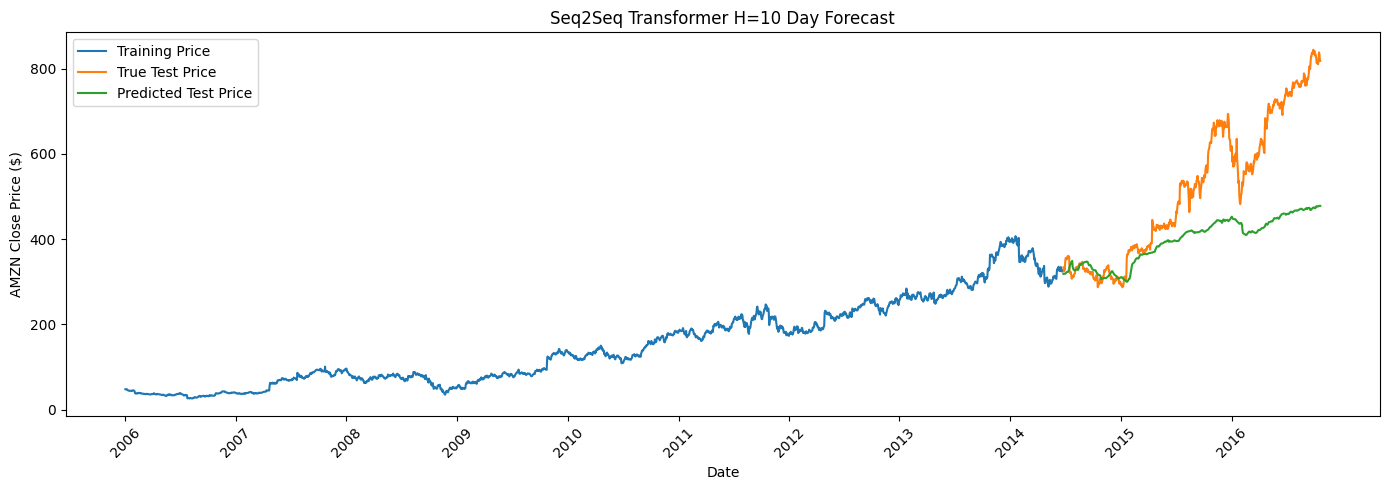

In [61]:
model_10.eval()
preds_scaled = []

with torch.no_grad():
    for xb, _ in test_loader:
        pred = model_10(xb.to(device))        
        pred = pred.cpu().numpy()
        preds_scaled.append(pred)

preds_scaled = np.vstack(preds_scaled)       
y_test_scaled = y_test.cpu().numpy()         


preds_h7 = preds_scaled[:, 6:7]  
true_h7  = y_test_scaled[:, 6:7]  

# inverse transform to get back true values
dummy_pred = np.zeros((len(preds_h7), data.shape[1]))
dummy_true = np.zeros((len(true_h7), data.shape[1]))

dummy_pred[:, TARGET_IDX] = preds_h7[:, 0]
dummy_true[:, TARGET_IDX] = true_h7[:, 0]

pred_close_h7 = scaler.inverse_transform(dummy_pred)[:, TARGET_IDX]
true_close_h7 = scaler.inverse_transform(dummy_true)[:, TARGET_IDX]

# metrics
mse_h7 = mean_squared_error(true_close_h7, pred_close_h7)
rmse_h7 = np.sqrt(mse_h7)

print("-" * 20)
print("H=10 Day Ahead Forecast")
print(f" MSE:  {mse_h7:.4f}")
print(f" RMSE: {rmse_h7:.4f}")
print("-" * 20)

plot_train = df["Close"].iloc[: train_size + SEQ_LEN].values
plot_dates = df["Date"].iloc[
    train_size + SEQ_LEN : train_size + SEQ_LEN + len(true_close_h7)
].apply(lambda x: x.toordinal())

plot_train_test_predictions(
    train=plot_train,
    test_true=true_close_h7,
    test_pred=pred_close_h7,
    dates=dates,
    title="Seq2Seq Transformer H=10 Day Forecast"
)

### Multi-step forecasting of 10 days

In [62]:
# Read Data, convert to sequences, split into train and test sets and load into DataLoaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)
features = ["Open","Close","Volume","High","Low"]
TARGET = "Close"
TARGET_IDX = features.index(TARGET)
data = df[features].values.astype(np.float32)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
SEQ_LEN = 75
TRAIN_RATIO = 0.7
FORECAST_HORIZON = 13

def create_sequences(arr, target_idx, seq_len, horizon):
    X, y = [], []
    for i in range(len(arr) - seq_len - horizon + 1):
        X.append(arr[i : i + seq_len])
        y.append(arr[i + seq_len : i + seq_len + horizon, target_idx])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(data_scaled, TARGET_IDX, SEQ_LEN, FORECAST_HORIZON)

N = len(X_all)

train_end = int(N * TRAIN_RATIO)
test_end  = int(N * 0.90)   # 70% + 20%
train_size = int(N * TRAIN_RATIO)
# ---- Train ----
X_train = torch.tensor(X_all[:train_end], dtype=torch.float32).to(device)
y_train = torch.tensor(y_all[:train_end], dtype=torch.float32).to(device)

# ---- Test ----
X_test = torch.tensor(X_all[train_end:test_end], dtype=torch.float32).to(device)
y_test = torch.tensor(y_all[train_end:test_end], dtype=torch.float32).to(device)

# ---- Validation ----
X_val = torch.tensor(X_all[test_end:], dtype=torch.float32).to(device)
y_val = torch.tensor(y_all[test_end:], dtype=torch.float32).to(device)


train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=1,
    shuffle=False
)

val_loader = DataLoader(
    TensorDataset(X_val, y_val),
    batch_size=1,
    shuffle=False
)

NUM_FEATURES = X_all.shape[-1]

In [65]:
model_13 = Seq2SeqTransformer(
    input_dim=NUM_FEATURES,
    d_model=128,
    heads=4,
    layers=3,
    d_ff=512,
    dropout=0.1,
    output_len=FORECAST_HORIZON
).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=1e-4)

EPOCHS = 25
print("Training Seq2Seq Transformer...")

train_loss_history = []
val_loss_history = []

for epoch in range(EPOCHS):
    # Train
    model_13.train()
    train_epoch_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()

        preds = model_13(xb, yb)
        loss = loss_fn(preds, yb)

        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()

    avg_train_loss = train_epoch_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # validation
    model_10.eval()
    val_epoch_loss = 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            preds = model_13(xb, yb)
            loss = loss_fn(preds, yb)

            val_epoch_loss += loss.item()

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {avg_train_loss:.6f} | "
        f"Val Loss: {avg_val_loss:.6f}"
    )


Training Seq2Seq Transformer...
Epoch 1/25 | Train Loss: 0.049683 | Val Loss: 0.101913
Epoch 2/25 | Train Loss: 0.009054 | Val Loss: 0.091756
Epoch 3/25 | Train Loss: 0.005093 | Val Loss: 0.080400
Epoch 4/25 | Train Loss: 0.002975 | Val Loss: 0.082109
Epoch 5/25 | Train Loss: 0.001958 | Val Loss: 0.083867
Epoch 6/25 | Train Loss: 0.001373 | Val Loss: 0.082066
Epoch 7/25 | Train Loss: 0.001099 | Val Loss: 0.073356
Epoch 8/25 | Train Loss: 0.000857 | Val Loss: 0.084818
Epoch 9/25 | Train Loss: 0.000703 | Val Loss: 0.079124
Epoch 10/25 | Train Loss: 0.000592 | Val Loss: 0.087448
Epoch 11/25 | Train Loss: 0.000506 | Val Loss: 0.086171
Epoch 12/25 | Train Loss: 0.000532 | Val Loss: 0.106649
Epoch 13/25 | Train Loss: 0.000439 | Val Loss: 0.102587
Epoch 14/25 | Train Loss: 0.000379 | Val Loss: 0.104897
Epoch 15/25 | Train Loss: 0.000368 | Val Loss: 0.091109
Epoch 16/25 | Train Loss: 0.000326 | Val Loss: 0.098161
Epoch 17/25 | Train Loss: 0.000308 | Val Loss: 0.096762
Epoch 18/25 | Train Loss:

--------------------
H=13 Day Ahead Forecast
 MSE:  28164.9323
 RMSE: 167.8241
--------------------


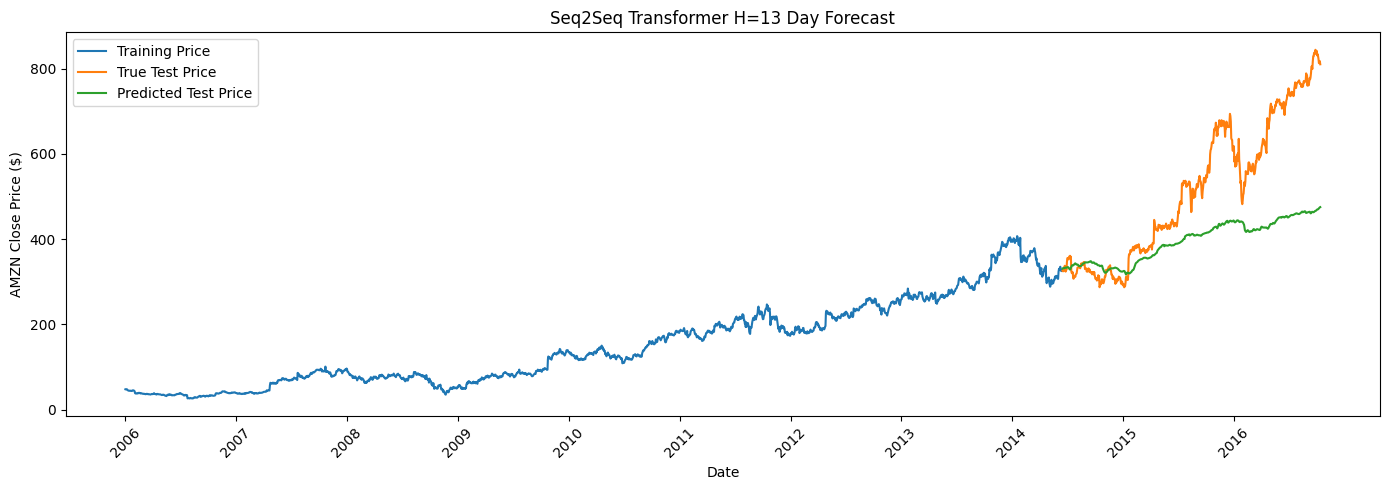

In [66]:
model_13.eval()
preds_scaled = []

with torch.no_grad():
    for xb, _ in test_loader:
        pred = model_10(xb.to(device))        
        pred = pred.cpu().numpy()
        preds_scaled.append(pred)

preds_scaled = np.vstack(preds_scaled)       
y_test_scaled = y_test.cpu().numpy()         


preds_h7 = preds_scaled[:, 6:7]  
true_h7  = y_test_scaled[:, 6:7]  

# inverse transform to get back true values
dummy_pred = np.zeros((len(preds_h7), data.shape[1]))
dummy_true = np.zeros((len(true_h7), data.shape[1]))

dummy_pred[:, TARGET_IDX] = preds_h7[:, 0]
dummy_true[:, TARGET_IDX] = true_h7[:, 0]

pred_close_h7 = scaler.inverse_transform(dummy_pred)[:, TARGET_IDX]
true_close_h7 = scaler.inverse_transform(dummy_true)[:, TARGET_IDX]

# metrics
mse_h7 = mean_squared_error(true_close_h7, pred_close_h7)
rmse_h7 = np.sqrt(mse_h7)

print("-" * 20)
print("H=13 Day Ahead Forecast")
print(f" MSE:  {mse_h7:.4f}")
print(f" RMSE: {rmse_h7:.4f}")
print("-" * 20)

plot_train = df["Close"].iloc[: train_size + SEQ_LEN].values
plot_dates = df["Date"].iloc[
    train_size + SEQ_LEN : train_size + SEQ_LEN + len(true_close_h7)
].apply(lambda x: x.toordinal())

plot_train_test_predictions(
    train=plot_train,
    test_true=true_close_h7,
    test_pred=pred_close_h7,
    dates=dates,
    title="Seq2Seq Transformer H=13 Day Forecast"
)